In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import json

# Read MoCap data and RoboRIO data form files

In [2]:
data_dir = "../../recorded_sensor_data/mocap_12_10-03-30-00/"
sensor_file = data_dir + "sensor_data.csv"
mocap_file = data_dir + "mocap_data.csv"
extra_points_file = data_dir + "extra_points.json"
sensor_reader = csv.reader(open(sensor_file, 'r'))
extra_points = json.load(open(extra_points_file, 'r'))
mocap_reader = csv.reader(open(mocap_file, 'r'))

MISSING_DATA = -123456789

# read offset to center of robot
template_centroid = np.array(extra_points['template_centroid'])
robot_center = np.array(extra_points['template_centroid'])
robot_center_offset = robot_center - template_centroid 

# skip headers
next(sensor_reader)
next(mocap_reader)
next(mocap_reader)
next(mocap_reader)
next(mocap_reader)
next(mocap_reader)

sensor_data = []
for sensor_row in sensor_reader:
    data = [float(d) for d in sensor_row]
    sensor_data.append(data)
sensor_data = np.array(sensor_data)

mocap_data = []
for mocap_row in mocap_reader:
    data = []
    for d in mocap_row:
        try:
            data.append(float(d))
        except ValueError:
            data.append(MISSING_DATA)
    mocap_data.append(data)
mocap_data = np.array(mocap_data)

In [3]:
def yawdiff(y1, y2):
    diff = y2 - y1
    if diff > np.pi:
        return diff - np.pi * 2;
    if diff < -np.pi:
        return diff + np.pi * 2;
    return diff;

### Check the amount of data between the two matches?

In [4]:
print("Seconds of IMU data recorded: ", (sensor_data[-1][-1] - sensor_data[0][-1])/1000.0)
print("Seconds of MoCap recorded:", len(mocap_data) / 100)

Seconds of IMU data recorded:  25.848
Seconds of MoCap recorded: 25.86


# Plot Mocap Data by Axis

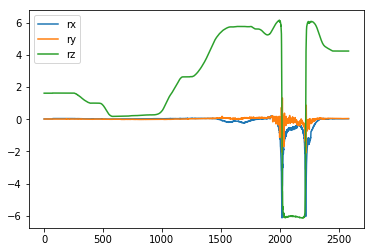

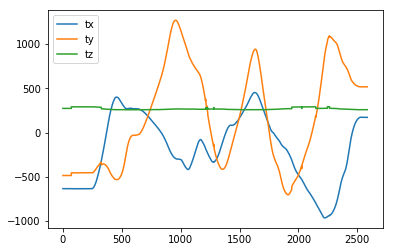

In [5]:
plt.plot(mocap_data[:,2], label="rx")
plt.plot(mocap_data[:,3], label="ry")
plt.plot(mocap_data[:,4], label="rz")
plt.legend()
plt.show()

plt.plot(mocap_data[:,5], label="tx")
plt.plot(mocap_data[:,6], label="ty")
plt.plot(mocap_data[:,7], label="tz")
plt.legend()
plt.show()

# Plot X/Y position from MoCap

In [6]:
mocap_states = np.ndarray((mocap_data.shape[0], 9))
mocap_state = np.zeros(9)
for mocap_idx in range(1, len(mocap_data)):
    data = mocap_data[mocap_idx]
    last_data = mocap_data[mocap_idx - 1]
    rx = data[2]
    ry = data[3]
    rz = data[4]
    tx = (data[5] + robot_center_offset[0]) / 1000
    ty = (data[6] + robot_center_offset[1]) / 1000
    tz = (data[7] + robot_center_offset[2]) / 1000
    mocap_state[0] = tx
    mocap_state[1] = ty
    drz = yawdiff(rz, last_data[4]) # handles wrap-around
    mocap_state[2] += drz
    mocap_states[mocap_idx-1] = mocap_state

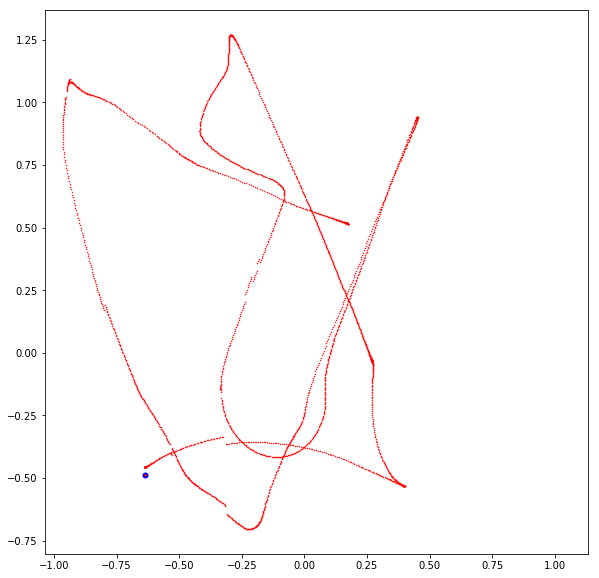

In [7]:
plt.figure(figsize=(10,10))
plt.scatter(mocap_states[0,0], mocap_states[0,1], marker='.', s=100, color='b')
plt.scatter(mocap_states[:,0], mocap_states[:,1], marker='.', s=1, color='r')
plt.axis("square")
plt.show()

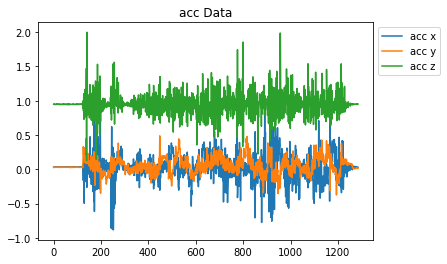

In [8]:
plt.plot(sensor_data[:,0], label="acc x")
plt.plot(sensor_data[:,1], label="acc y")
plt.plot(sensor_data[:,2], label="acc z")
plt.title("acc Data")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

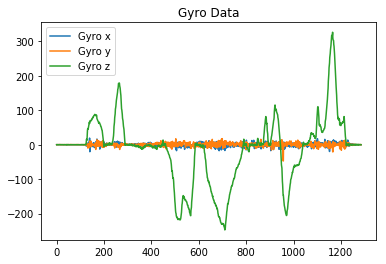

In [9]:
plt.plot(sensor_data[:,3], label="Gyro x")
plt.plot(sensor_data[:,4], label="Gyro y")
plt.plot(sensor_data[:,5], label="Gyro z")
plt.title("Gyro Data")
plt.legend()
plt.show()

In [10]:
yaws = []
yaw = 0
last_t = sensor_data[0][-1]
for data in sensor_data:
    gyro_z = data[5]
    dt_s = data[-1] - last_t
    yaw += dt_s * gyro_z
    yaws.append(yaw)
    last_t = data[-1]

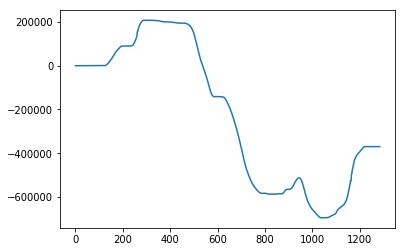

In [11]:
plt.plot(yaws, label="integrated gyro")
plt.show()

# X/Y from NavX

In [12]:
# adjust the NavX data to start with the correct X/Y
navx_x = sensor_data[:,6] - sensor_data[0,6] + mocap_states[0][0]
navx_y = sensor_data[:,7] - sensor_data[0,7] + mocap_states[0][1]

# Encoder

In [13]:
# encoder kinematics
encoder_x = mocap_states[0][0]
encoder_y = mocap_states[0][1]
encoder_theta = mocap_states[0][2]
encoder_xs = []
encoder_ys = []
alpha = 1.0
wheel_radius_m = 0.072
track_width_m = 0.9
dt_s = 0.02

pulse_per_revolution = 128
distance_per_pulse =(wheel_radius_m * 2 * np.pi) /  pulse_per_revolution
print(distance_per_pulse)

for data in sensor_data:
    wl = float(data[9]) * distance_per_pulse
    wr = float(data[10]) * distance_per_pulse
    
    B = alpha * track_width_m
    T = wheel_radius_m / B * np.array([[B / 2.0, B / 2.0], [-1, 1]])
    dydt, dpdt = T @ np.array([wl, wr])
    encoder_x = encoder_x + np.cos(encoder_theta) * dydt * dt_s
    encoder_y = encoder_y + np.sin(encoder_theta) * dydt * dt_s
    encoder_theta += dpdt * dt_s
    
    encoder_xs.append(encoder_x)
    encoder_ys.append(encoder_y)

0.003534291735288517


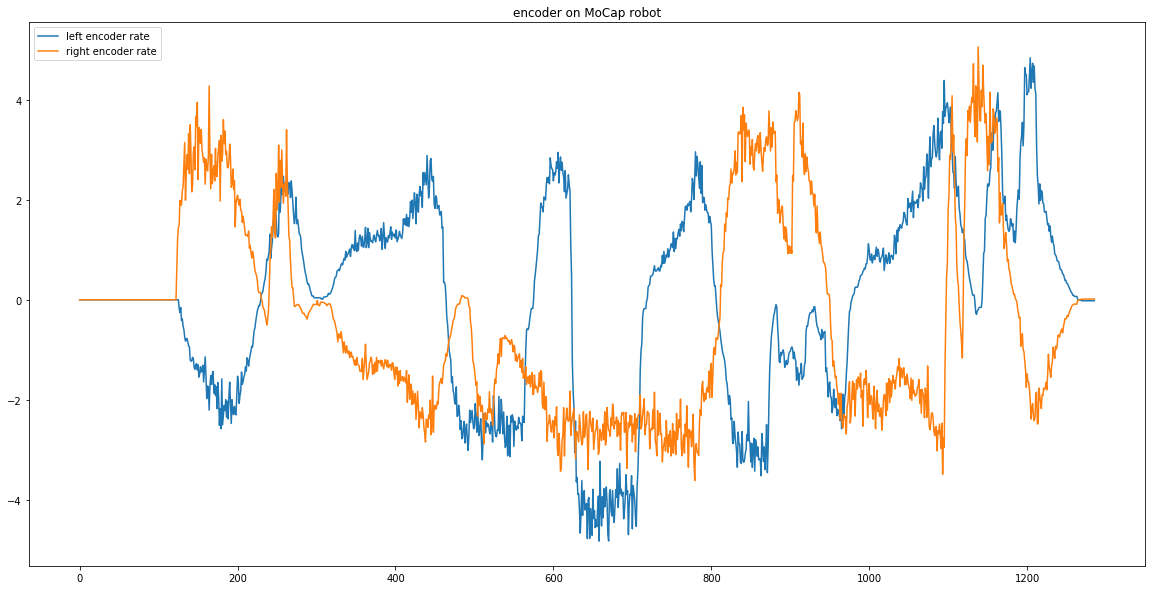

In [14]:
plt.figure(figsize=(20,10))
#640,700 is a constant-speed interval
plt.plot(sensor_data[:,9]*distance_per_pulse,label='left encoder rate')
plt.plot(sensor_data[:,10]*distance_per_pulse, label='right encoder rate')
plt.title("encoder on MoCap robot")
plt.legend()
plt.show()

## Double Integrating Accelerometer

In [15]:
def DoubleIntegrate(accelerometer_data, K, T, b, x0=0, y0=0, dt_s=0.02):
    x = x0
    y = y0
    vx = 0
    vy = 0
    xs = []
    ys = []
    vxs = []
    vys = []
    axs = []
    ays = []
    
    for a_s in accelerometer_data:
        a_o = T@K@(a_s+b).T
        ax = a_o[0][0]
        ay = a_o[1][0]
        
        vx += ax * dt_s
        vy += ay * dt_s
        x += vx * dt_s + 0.5 * ax * dt_s ** 2
        y += vy * dt_s + 0.5 * ay * dt_s ** 2
        axs.append(ax)
        ays.append(ay)
        vxs.append(vx)
        vys.append(vy)
        xs.append(x)
        ys.append(y)
    
    return xs, ys, vxs, vys, axs, ays

Average Accel X value: 0.033876953
Average Accel Y value: 0.029166262
Average Accel Z value: 0.94774169


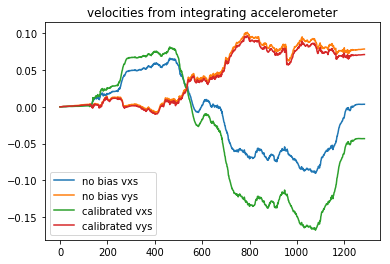

In [16]:
means = np.mean(sensor_data[:100],axis=0)
print("Average Accel X value:", means[0])
print("Average Accel Y value:", means[1])
print("Average Accel Z value:", means[2])

K = np.array([[1,0,0],[0,1,0],[0,0,1]])*0.01
T = np.array([[1,0,0.01],[0,1,0],[0,0,1]])
b = np.array([[-means[0], -means[1], 0]])
no_bias = DoubleIntegrate(sensor_data[:,3:6], K, np.eye(3), np.array([[0,0,0]]), x0=mocap_states[0][0], y0=mocap_states[0][1])
calib = DoubleIntegrate(sensor_data[:,3:6], K, T, b, x0=mocap_states[0][0], y0=mocap_states[0][1])

plt.plot(no_bias[2], label="no bias vxs")
plt.plot(no_bias[3], label="no bias vys")
plt.plot(calib[2], label="calibrated vxs")
plt.plot(calib[3], label="calibrated vys")
plt.title("velocities from integrating accelerometer")
plt.legend()
plt.show()

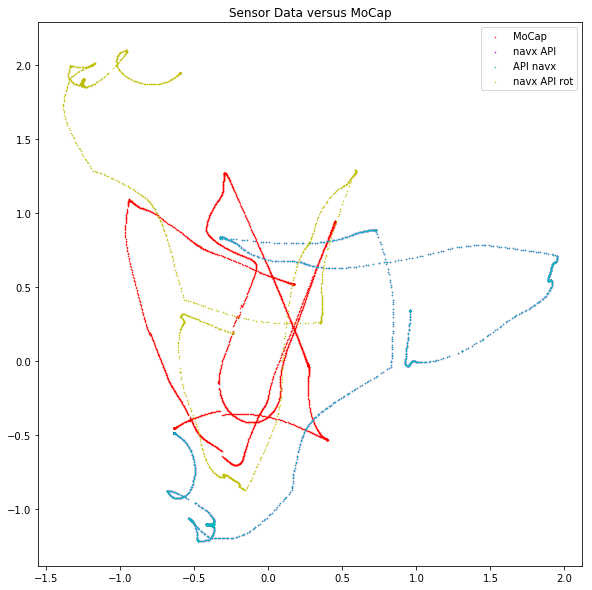

In [40]:
plt.figure(figsize=(10,10))
plt.title("Sensor Data versus MoCap")
# all this acc stuff is wrong!
# plt.scatter(no_bias[0], no_bias[1], marker='.', s=1, color='b', label='Accelerometer, no bias')
# plt.scatter(calib[0], calib[1], marker='.', s=1, color='g', label='Accelerometer, with bias')
# plt.plot(encoder_xs, encoder_ys, color='k', label='encoders')
plt.scatter(mocap_states[:,0], mocap_states[:,1], marker='.', s=1, color='r', label='MoCap')
plt.scatter(navx_x, navx_y, marker='.', s=1, color='m', label="navx API")
tt = -1.85
xx = -.3
yy = 1.2
RR = np.array([[np.cos(tt), -np.sin(tt), 0, xx], [np.sin(tt), np.cos(tt), 0, yy], [0, 0, 1, 0], [0, 0, 0, 1]])
dd = RR @ np.array([navx_x, navx_y, np.zeros(navx_x.shape[0]), np.ones(navx_x.shape[0])])
plt.scatter(navx_x, navx_y, marker='.', s=1, color='c', label="API navx")
plt.scatter(dd[0,:], dd[1,:], marker='.', s=1, color='y', label="navx API rot")
plt.axis("square")

plt.legend()
plt.show()

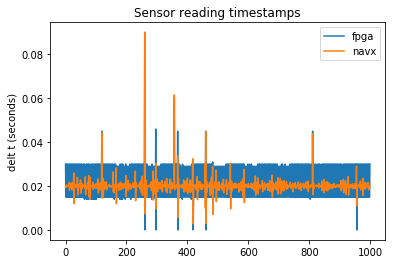

In [20]:
dts_fpgas = []
dts_navxs = []
for i in range(1000):
    dt_s_fpga = (sensor_data[i+1][-1] - sensor_data[i][-1]) / 1000
    dt_s_navx = (sensor_data[i+1][-2] - sensor_data[i][-2])
    dts_fpgas.append(dt_s_fpga)
    dts_navxs.append(dt_s_navx)
    
plt.plot(dts_fpgas, label='fpga')
plt.plot(dts_navxs, label='navx')
plt.ylabel("delt t (seconds)")
plt.legend()
plt.title("Sensor reading timestamps")
plt.show()

## Testing on Turtlebot accelerometer data

Average Init Accel X value: -0.00868075200457
Average Init Accel Y value: 0.0075272353263
Average Accel X value: -0.00999664059554
Average Accel Y value: 0.00540464022406


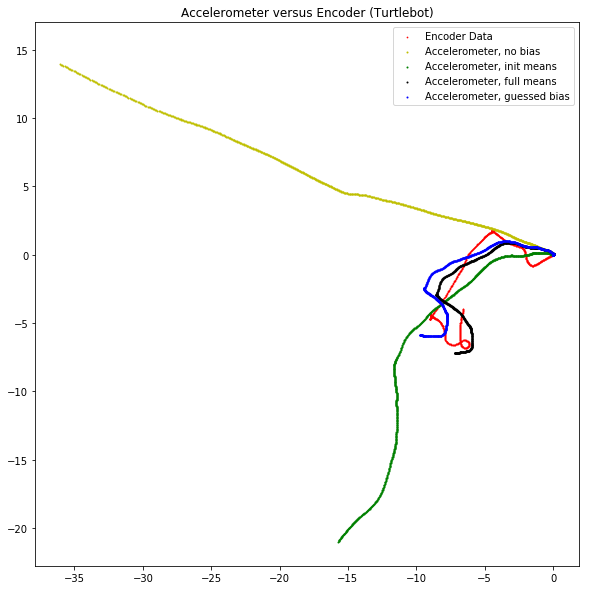

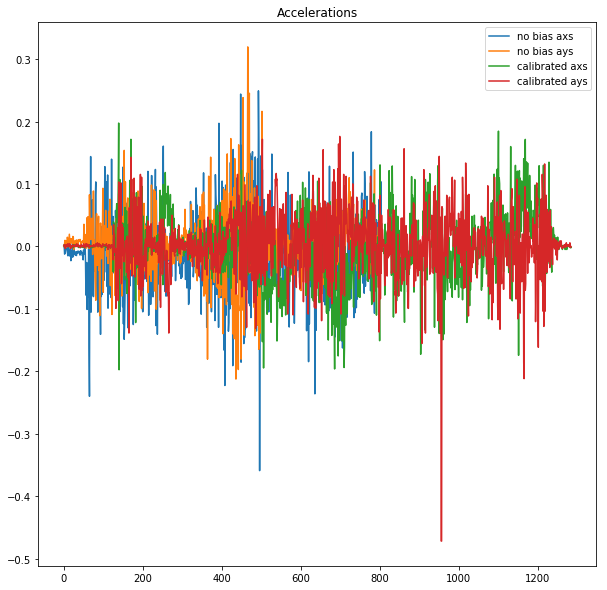

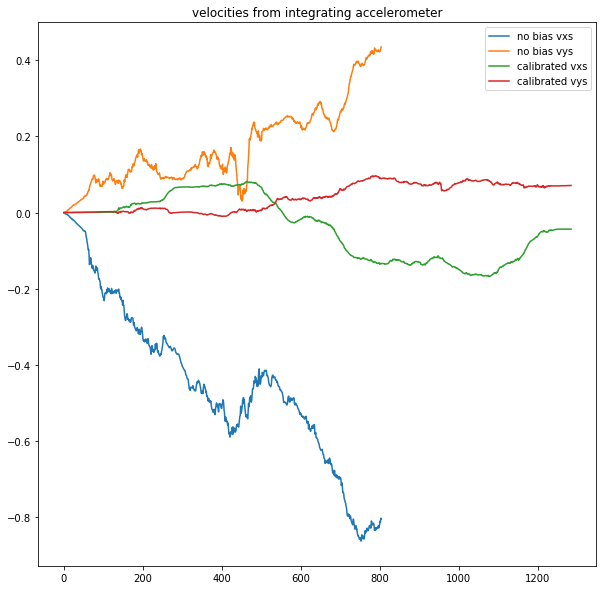

In [21]:
turtlebot_dir = "../../recorded_sensor_data/turtlebot_original/"
data_file = turtlebot_dir + "interpolated_data.csv"
reader = csv.reader(open(data_file, 'r'))

accelerometer_data = []
encoder_x = 0
encoder_y = 0
encoder_theta = 0.5
encoder_xs = []
encoder_ys = []
alpha = 1.0
wheel_radius_m = 0.038
track_width_m = 0.23
dt_s = 0.1

next(reader)
for data in reader:
    wl = float(data[0])
    wr = float(data[1])
    ax = float(data[2])
    ay = float(data[3])
    t = float(data[-1])
    
    accelerometer_data.append([ax, ay, t])
    B = alpha * track_width_m
    T = wheel_radius_m / B * np.array([[B / 2.0, B / 2.0], [-1, 1]])
    dydt, dpdt = T @ np.array([wl, wr])
    encoder_x = encoder_x + np.cos(encoder_theta) * dydt * dt_s
    encoder_y = encoder_y + np.sin(encoder_theta) * dydt * dt_s
    encoder_theta += dpdt * dt_s
    
    encoder_xs.append(encoder_x)
    encoder_ys.append(encoder_y)
    
init_means = np.mean(accelerometer_data[:40], axis=0)
full_means = np.mean(accelerometer_data, axis=0)
print("Average Init Accel X value:", init_means[0])
print("Average Init Accel Y value:", init_means[1])
print("Average Accel X value:", full_means[0])
print("Average Accel Y value:", full_means[1])

no_bias = DoubleIntegrate(accelerometer_data, np.eye(3), np.eye(3), np.zeros((1,3)), dt_s=0.1)
K = np.eye(3)*50
T = np.eye(3)
b = np.array([[-init_means[0], -init_means[1], 0]])
init_calib = DoubleIntegrate(accelerometer_data, K, T, b)
b = np.array([[-full_means[0], -full_means[1], 0]])
full_calib = DoubleIntegrate(accelerometer_data, K, T, b)
b = np.array([[0.0096, -0.0052, 0]])
guess_calib = DoubleIntegrate(accelerometer_data, K, T, b)

plt.figure(figsize=(10,10))
plt.scatter(encoder_xs, encoder_ys, marker='.', s=2, color='r', label='Encoder Data')
plt.scatter(no_bias[0], no_bias[1], marker='o', s=1, color='y', label='Accelerometer, no bias')
plt.scatter(init_calib[0], init_calib[1], marker='o', s=1, color='g', label='Accelerometer, init means')
plt.scatter(full_calib[0], full_calib[1], marker='o', s=1, color='k', label='Accelerometer, full means')
plt.scatter(guess_calib[0], guess_calib[1], marker='o', s=1, color='b', label='Accelerometer, guessed bias')
plt.title("Accelerometer versus Encoder (Turtlebot)")
plt.axis("square")
plt.legend(prop={'size': 10})
plt.show()

plt.figure(figsize=(10,10))
plt.plot(no_bias[4], label="no bias axs")
plt.plot(no_bias[5], label="no bias ays")
plt.plot(calib[4], label="calibrated axs")
plt.plot(calib[5], label="calibrated ays")
plt.title("Accelerations")
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
plt.plot(no_bias[2], label="no bias vxs")
plt.plot(no_bias[3], label="no bias vys")
plt.plot(calib[2], label="calibrated vxs")
plt.plot(calib[3], label="calibrated vys")
plt.title("velocities from integrating accelerometer")
plt.legend()
plt.show()

# Camera Stuff

In [22]:
import cv2

In [23]:
img_dir = "../../recorded_sensor_data/practice_image_processing/"
vid_file = img_dir + "out.avi"
vid = cv2.VideoCapture(vid_file)
img_timestamp_file = img_dir + "frame_time_stamps.csv"
img_timestamp_reader = csv.reader(open(img_timestamp_file))
camera_xs = []
camera_ys = []
for timestamp in img_timestamp_reader:
    t = float(timestamp[0])
    ok, frame = vid.read()
    
    # (t, frame)
    # detect markers in frame
    
    # compute position relative to markers
    camera_x = 0
    camera_y = 0
    
    camera_xs.append(camera_x)
    camera_ys.append(camera_y)
    
    if not ok:
        break

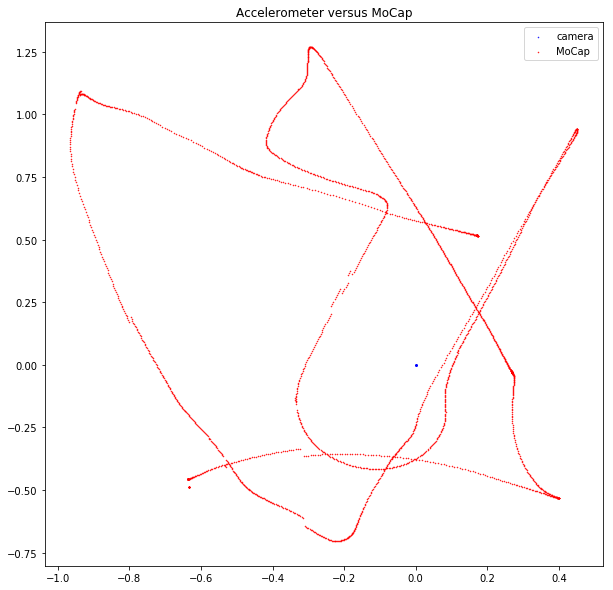

In [24]:
plt.figure(figsize=(10,10))
plt.scatter(camera_xs, camera_ys, marker='.', s=1, color='b', label='camera')
plt.scatter(mocap_states[:,0], mocap_states[:,1], marker='.', s=1, color='r', label='MoCap')
plt.title("Accelerometer versus MoCap")
plt.legend()
plt.show()